# Simulation of temperature profile evolution in permafrost

This notebook creates and runs a one-dimensional simulation model of temperature evolution under sinusoidal forcing.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

The block below defines the code for the model:

In [2]:
class HeatConductionSimulator(object):
    
    _ONE_DAY = 24.0 * 60.0 * 60.0
    _ONE_YEAR = 365.25 * _ONE_DAY

    def __init__(self,
                 thermal_diffusivity=1.0e-6,
                 surface_temp=-5.0,
                 amplitude=10.0,
                 period=24.0 * 3600.0,
                 profile_depth=1.0,
                 geotherm=0.025,
                 num_nodes=101,
                 diffusion_number=0.2,
                ):
        """Initialize the HeatConductionSimulator.

        Parameters
        ----------
        thermal_diffusivity: float
            Thermal diffusivity, in m2/s (default 10^-6)
        surface_temp: float
            Mean surface temperature, degrees C (default -5)
        amplitude: float
            Amplitude of daily temperature excursions from the mean, degrees C (default 10)
        period: float
            Period of temperature variation, s (default 1 day = 86,400 s)
        profile_depth: float
            Depth of profile, m (default 1 m)
        geotherm: float
            Background geothermal gradient (default 0.025 deg C / m)
        num_nodes: int
            Number of nodes (default 101)
        diffusion_number: float
            Dimensionless diffusion number = D dt / dz^2 (default 0.2)
        """
        self.profile_depth = profile_depth
        self.surface_temp = surface_temp
        self.amplitude = amplitude
        self.period = period
        self.alpha = diffusion_number  # must be <= 1/2 for numerical stability
        self.dz = profile_depth / (num_nodes - 1)
        self.timestep_duration = self.alpha * self.dz * self.dz / thermal_diffusivity

        self.depth = np.linspace(0, profile_depth, num_nodes)
        self.temp = surface_temp + geotherm * self.depth
        self.current_time = 0.0
        self.max_act_layer_depth = 0.0    
        
    def run_one_step(self):
        """Advance for one time step"""
        self.temp[0] = (self.surface_temp + 
                        self.amplitude * np.sin(2.0 * np.pi * self.current_time / self.period))
        self.temp[1:-1] += self.alpha * (self.temp[2:] - 2 * self.temp[1:-1] + self.temp[:-2])
        self.current_time += self.timestep_duration

    def run_n_steps(self, n):
        for i in range(n):
            self.run_one_step()

The function below initializes and runs the model, and generates and displays and animation of the result. Here, we are using default parameters:

In [3]:
def run_model(num_days=2.0,
              thermal_diffusivity=1.0e-6,
              surface_temp=-5.0,
              amplitude=10.0,
              period=24.0 * 3600.0,
              profile_depth=1.0,
              geotherm=0.025,
              num_nodes=101,
              save_every=100,
              diffusion_number=0.2,
             ):
    """Initialize, run, and display output from model.
    
    Parameters
    ----------
    num_days: float
        Number of days to run
    thermal_diffusivity: float
        Thermal diffusivity, in m2/s (default 10^-6)
    surface_temp: float
        Mean surface temperature, degrees C (default -5)
    amplitude: float
        Amplitude of daily temperature excursions from the mean, degrees C (default 10)
    period: float
        Period of temperature variation, s (default 1 day = 86,400 s)
    profile_depth: float
        Depth of profile, m (default 1 m)
    geotherm: float
        Background geothermal gradient (default 0.025 deg C / m)
    num_nodes: int
        Number of nodes (default 101)
    save_every: int
        Interval to save an animation frame, in iterations (default 100)
    diffusion_number: float
        Dimensionless diffusion number = D dt / dz^2 (default 0.2)
    """

    # Instantiate and initialize a simulator
    hcs = HeatConductionSimulator(thermal_diffusivity=thermal_diffusivity,
                                  profile_depth=profile_depth,
                                  geotherm=geotherm,
                                  surface_temp=surface_temp,
                                  amplitude=amplitude,
                                  period=period,
                                  num_nodes=num_nodes,
                                  diffusion_number=diffusion_number,
                                 )
    
    # Calculate number of animation iterations
    nsteps = int(num_days * 24.0 * 3600.0 / (hcs.timestep_duration * save_every))
    
    # Set up a blank figure with placeholder lists for data
    fig, ax = plt.subplots()
    xdata = []
    ydata = []
    obj = ax.plot([], [], color = 'k')
    
    # Then, set up an initialization function
    def init():
        ax.set_ylim(0, hcs.profile_depth)
        ax.set_xlim(hcs.surface_temp - hcs.amplitude, hcs.surface_temp + hcs.amplitude)
        ax.set_ylabel('Depth (m)')
        ax.set_xlabel('Temperature (degrees C)')
        return(obj)
    
    # Next, define the update function
    def update(i):
        ax.cla()
        hcs.run_n_steps(save_every)
        xdata = hcs.temp
        ydata = hcs.depth
        ax.set_ylim(0, hcs.profile_depth)
        xmin = hcs.surface_temp - hcs.amplitude
        xmax = hcs.surface_temp + hcs.amplitude
        ax.set_xlim(xmin, xmax)
        ax.set_ylabel('Depth (m)')
        ax.set_xlabel('Temperature (degrees C)')
        ax.invert_yaxis()
        obj = ax.plot(xdata, ydata, color = 'r')
        obj = ax.plot([0.0, 0.0], [0.0, hcs.profile_depth], 'k--')
        if np.amax(hcs.temp) > 0.0:
            above_zero = np.where(hcs.temp > 0.0)[0]
            z_active_layer = hcs.depth[above_zero[-1]]
            obj = ax.plot([xmin, xmax], [z_active_layer, z_active_layer], 'b')
            if z_active_layer > hcs.max_act_layer_depth:
                hcs.max_act_layer_depth = z_active_layer
        return(obj)
    
    # Run the animation!
    anim = FuncAnimation(fig, update, nsteps, init_func=init, blit = True)
    
    # Convert the animation to HTML
    vid = HTML(anim.to_html5_video())
    
    # Report maximum active layer depth
    print('Maximum active layer depth: ' + str(hcs.max_act_layer_depth) + ' meters')
    
    return vid

## An example model run with default parameters

Maximum active layer depth: 0.13 meters


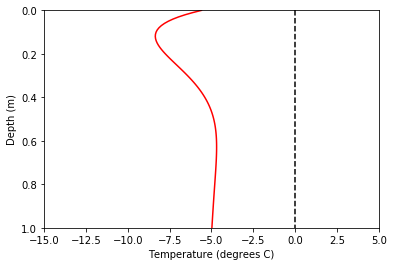

In [4]:
my_movie = run_model()
my_movie

## An example of changing parameters to simulate seasonal temperature cycles

Maximum active layer depth: 4.2 meters


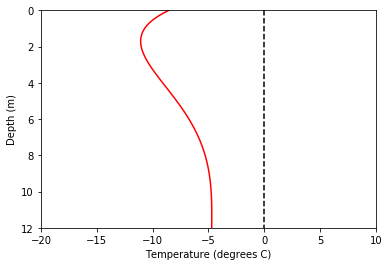

In [9]:
my_movie = run_model(num_days=365.25*2, amplitude=15., period=365.25*24*3600.0, profile_depth=12.,
                     save_every=500)
my_movie

## Your turn

Use the cells below to experiment with running the model with different parameters and/or boundary conditions, as indicated in the lab exercise. To run the model and produce a movie, use `my_movie = run_model(`*keyword parameters*`)`. The main parameters that you might want to explore include:

-    num_days: Number of days to run (default 2)
-    thermal_diffusivity: Thermal diffusivity, in m2/s (default 10^-6)
-    surface_temp: Mean surface temperature, degrees C (default -5)
-    amplitude: Amplitude of daily temperature excursions from the mean, deg C (default 10)
-    period: Period of temperature variation, s (default 1 day = 86,400 s)
-    profile_depth: Depth of profile, m (default 1 m)

For example, to run a model with a thermal diffusivity of $2\times 10^6$ m$^2$/s and a mean surface temperature of -10 $^\circ$C, you would create and run a new cell with the code:

`my_movie = run_model(thermal_diffusivity=2.0e-6, surface_temp=-10.0)`

`my_movie`